In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatches
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import keras.layers as layers
import sklearn.metrics as metrics
import kagglehub
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
import cv2 as cv
import random
import torch
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T, DatasetMapper
from detectron2.data import build_detection_train_loader
from detectron2.utils.visualizer import ColorMode


# Original dataset
#path = kagglehub.dataset_download("saurabhshahane/mnist-for-object-detection")
#im_path = "/Users/quino070/.cache/kagglehub/datasets/saurabhshahane/mnist-for-object-detection/versions/1/mnist_detection"
im_path = "/Users/quino070/LeafShapeAnalysis/mnist_detection"


In [5]:
def get_labels(set: str) -> pd.DataFrame:
    folder = f"{im_path}/{set}/labels/"
    dfs = []

    for name in sorted(os.listdir(folder)):
        df = pd.read_csv(folder + name)
        df["file_name"] = name.replace(".txt", "")
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

train_labels = get_labels("train")
test_labels = get_labels("test")

In [6]:
train_images_name = sorted(os.listdir(f"{im_path}/train/images"))
test_images_name = sorted(os.listdir(f"{im_path}/test/images"))

In [7]:
def get_detectron_dicts(tset,images_name, labels):
    dataset_dicts = []

    for idx, img_path in enumerate(images_name):
        record = {}
        # Access image and record dimensions
        filename = img_path
        image = cv.imread(f'{im_path}/{tset}/images/{filename}')
        height, width = image.shape[:2]

        record["file_name"] = im_path+"/"+tset+"/images/"+filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        # get annotation row for this image
        row = labels[labels["file_name"] == filename.replace(".png", "")].iloc[0]

        obj = {
            "bbox": [
                int(row["xmin"]), 
                int(row["ymin"]), 
                int(row["xmax"]), 
                int(row["ymax"])
            ],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": int(row["label"]),
            "iscrowd": 0,
        }

        record["annotations"] = [obj]
        dataset_dicts.append(record)

    return dataset_dicts

In [5]:
digit_train = get_detectron_dicts("train",train_images_name, train_labels)
digit_test = get_detectron_dicts("test",test_images_name, test_labels)

In [6]:
DatasetCatalog.register("digit_train", lambda: digit_train)

MetadataCatalog.get("digit_train").set(thing_classes=[str(i) for i in range(10)])

DatasetCatalog.register("digit_test", lambda: digit_test)

MetadataCatalog.get("digit_test").set(thing_classes=[str(i) for i in range(10)])

namespace(name='digit_test',
          thing_classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [7]:
def visualize_dataset(datasetname, tset, n_samples=10):

    dataset_dicts = DatasetCatalog.get(datasetname)
    metadata = MetadataCatalog.get(datasetname)

    for d in random.sample(dataset_dicts,n_samples):
        fn = d['file_name']
        print(fn)
        img = cv.imread(fn)
        visualizer = Visualizer(img[:, :, ::-1],
        metadata=metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        plt.figure(num=None, figsize=(15, 15), dpi=100, facecolor='w', edgecolor='k')
        plt.axis("off")
        plt.imshow(vis.get_image()[:, :, ::-1])
        plt.show()

/Users/quino070/LeafShapeAnalysis/mnist_detection/train/images/9100_2.png


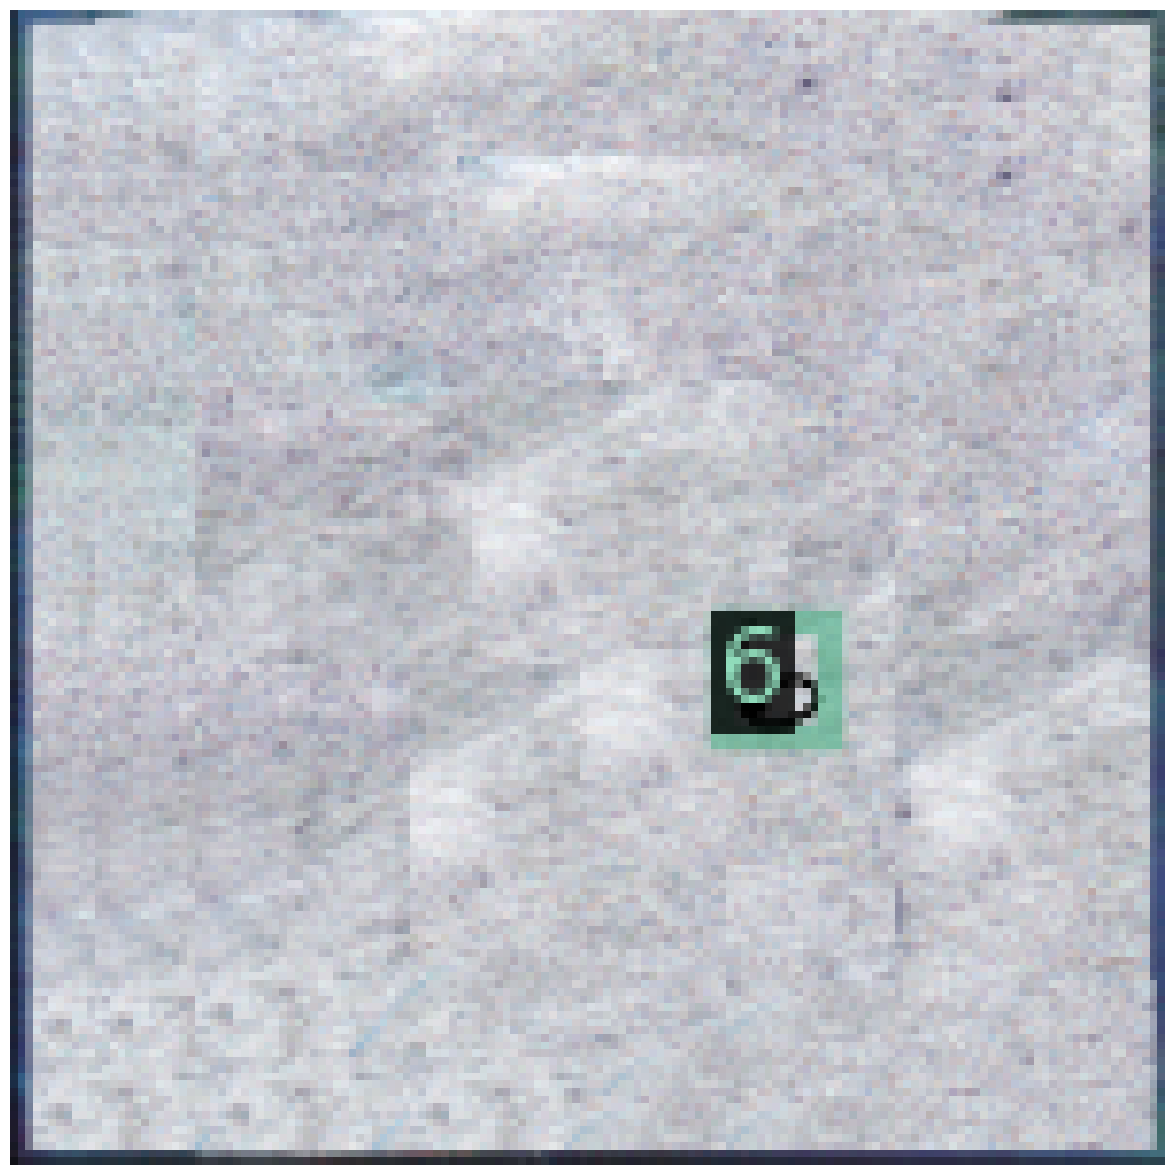

/Users/quino070/LeafShapeAnalysis/mnist_detection/train/images/6926_1.png


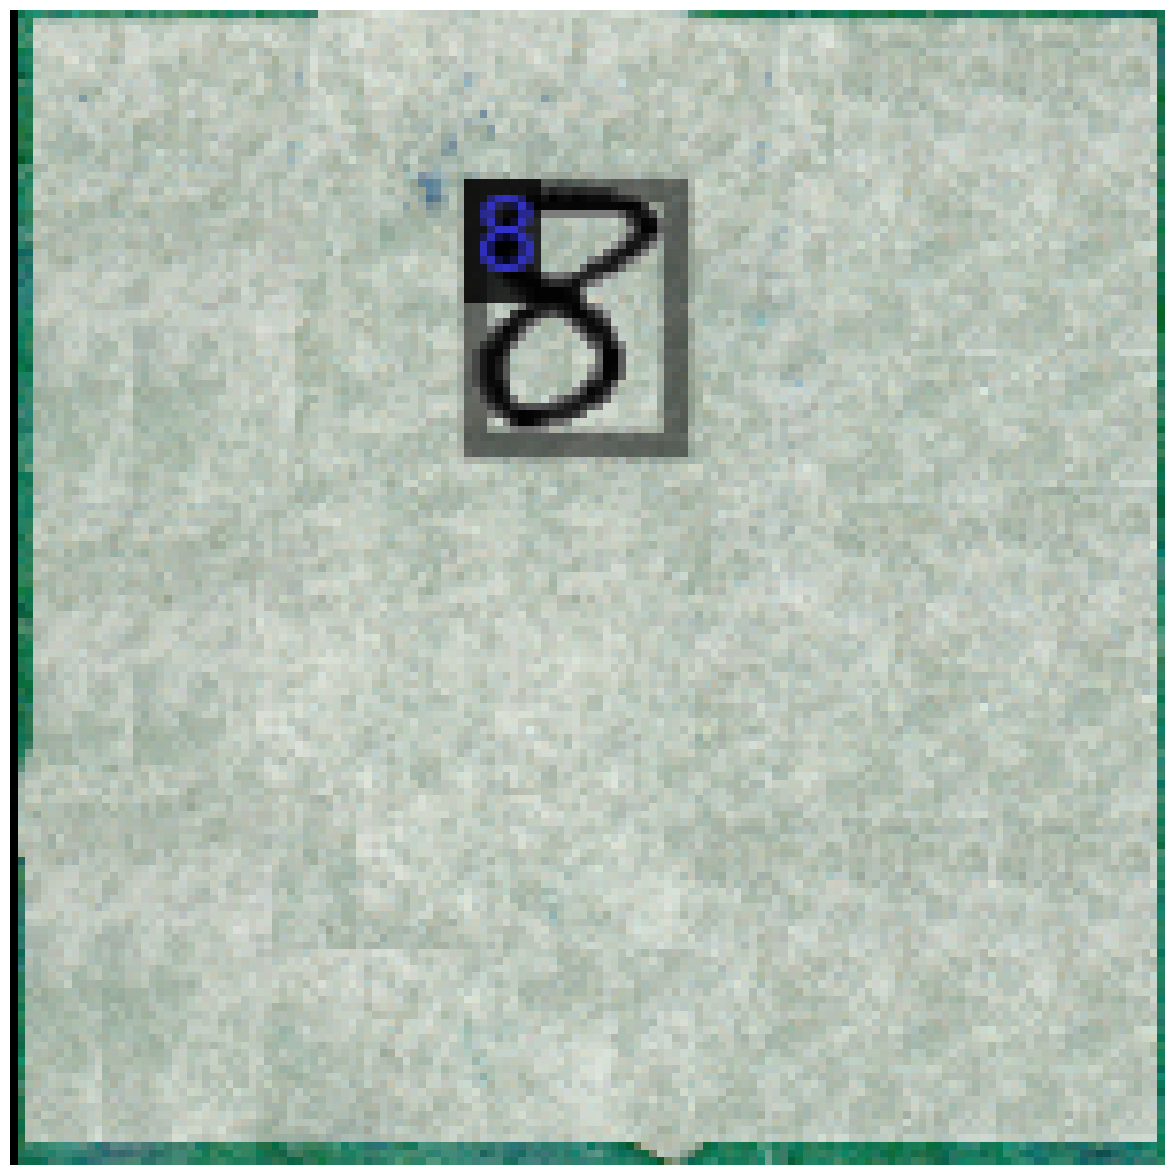

/Users/quino070/LeafShapeAnalysis/mnist_detection/train/images/6296.png


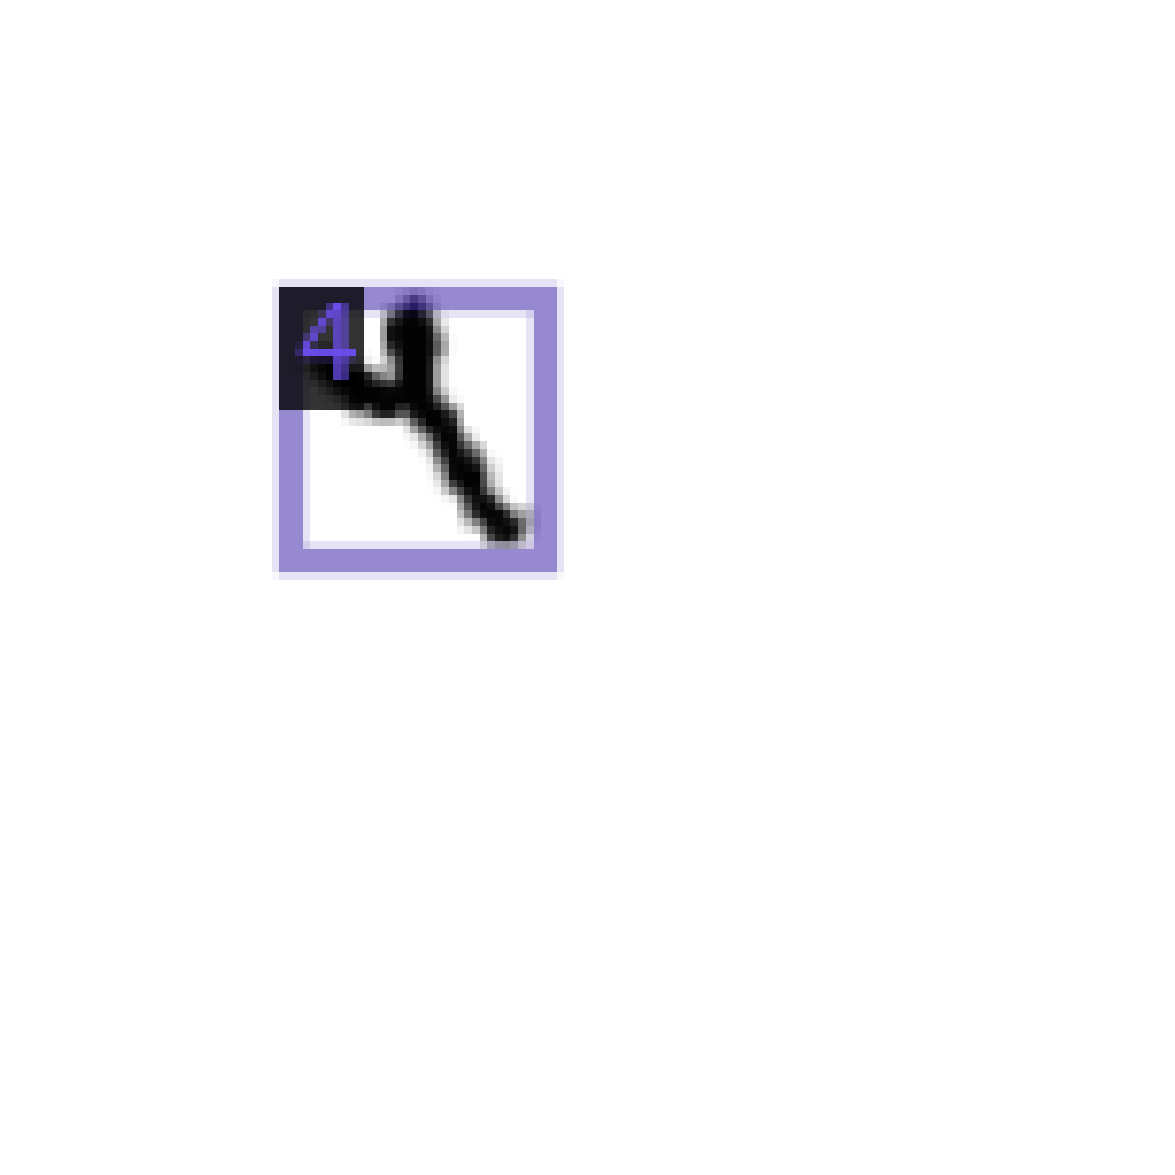

/Users/quino070/LeafShapeAnalysis/mnist_detection/train/images/9624.png


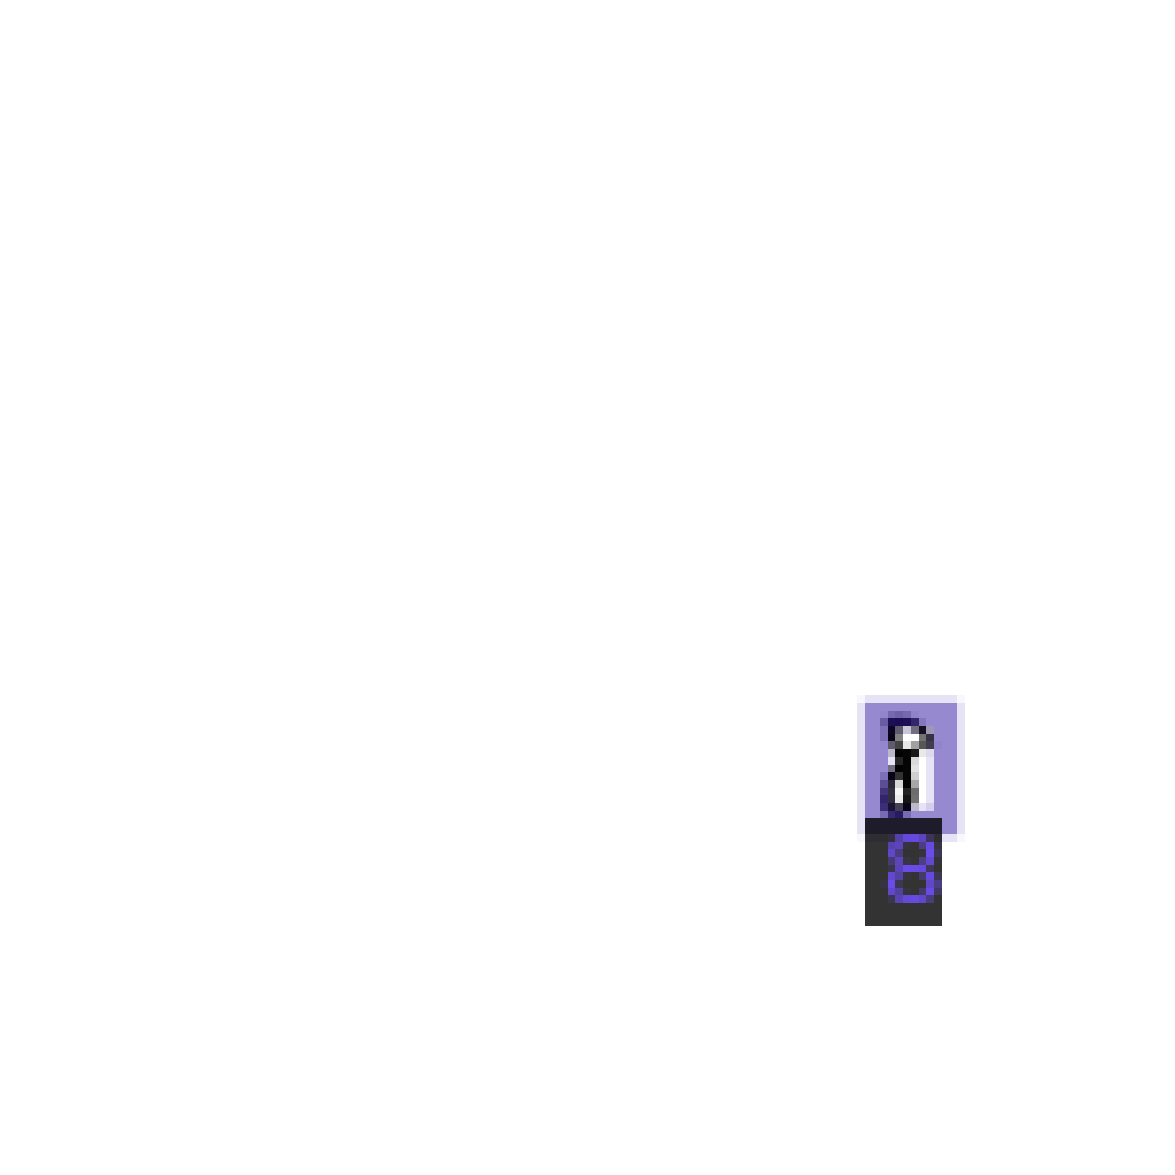

/Users/quino070/LeafShapeAnalysis/mnist_detection/train/images/1025.png


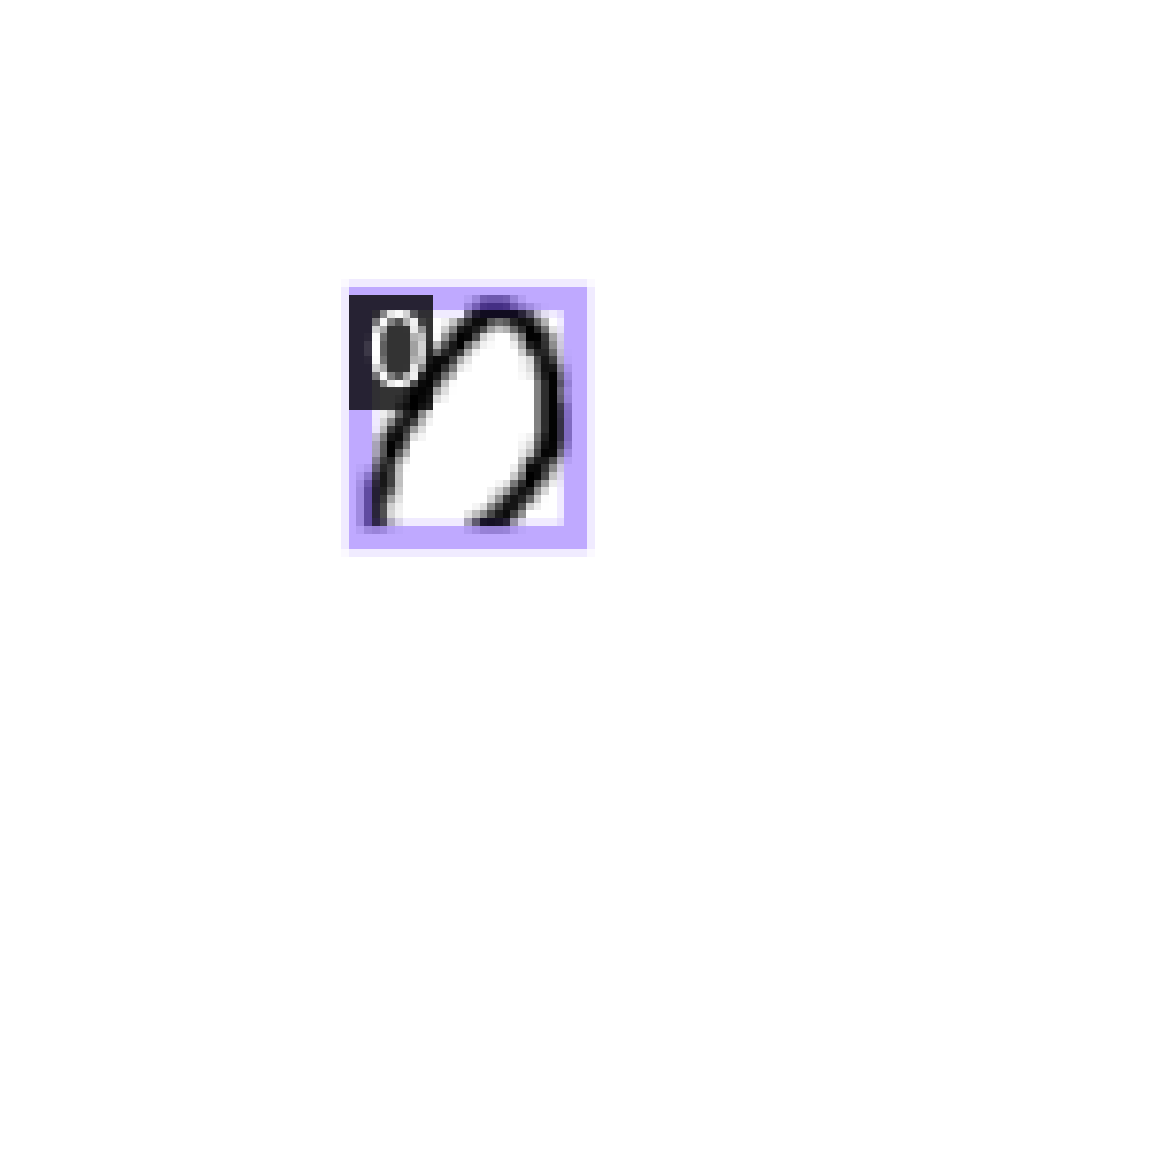

In [8]:
visualize_dataset("digit_train", "train", 5)

In [9]:
class CustomTrainer(DefaultTrainer):
    """
    A Trainer that overrides the default data loader to include custom augmentations,
    including random horizontal and vertical flips.
    """
    @classmethod
    def build_train_loader(cls, cfg):
        # Define your custom augmentations as a list of Augmentation objects
        augmentations = [
            #T.RandomBrightness(0.75, 1.3),  # Example: Random brightness adjustment
            #T.RandomContrast(0.75, 1.3),    # Example: Random contrast adjustment
            T.RandomRotation(angle=[-30, 30], expand=False), # Example: Random rotation
            # Augmentation for random horizontal flip (mirror on x-axis)
            #T.RandomFlip(prob=0.5, horizontal=True, vertical=False), 
            # Augmentation for random vertical flip (mirror on y-axis)
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True), 
            T.ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice'), # Default resize
        ]
        
        # Create a custom mapper with your augmentations
        mapper = DatasetMapper(cfg, is_train=True, augmentations=augmentations)
        
        # Build and return the data loader
        return build_detection_train_loader(cfg, mapper=mapper)

In [8]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"

cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml")
)

# Datasets
cfg.DATASETS.TRAIN = ("digit_train",)
cfg.DATASETS.TEST = ("digit_test",)

# Dataloader
cfg.DATALOADER.NUM_WORKERS = 2

# Weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/retinanet_R_50_FPN_1x.yaml"
)

# Solver
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 1e-4
cfg.SOLVER.MAX_ITER = 4000
cfg.SOLVER.STEPS = []
cfg.SOLVER.WARMUP_ITERS = 500

# RetinaNet-specific
cfg.MODEL.RETINANET.NUM_CLASSES = 10
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.25

# Image size (important for your 300x300 data)
cfg.INPUT.MIN_SIZE_TRAIN = (300,)
cfg.INPUT.MAX_SIZE_TRAIN = 300
cfg.INPUT.MIN_SIZE_TEST = 300
cfg.INPUT.MAX_SIZE_TEST = 300

# Output
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# -----------------------------
# Train
# -----------------------------
#trainer = CustomTrainer(cfg)
#trainer.resume_or_load(resume=False)
#trainer.train()

Loading config /Users/quino070/LeafShapeAnalysis/detectron2/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [11]:
%load_ext tensorboard
%tensorboard --logdir output --host localhost

In [9]:
#Loading in model for inference
# 2. Set the path to your saved model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # <-- your trained model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # threshold for predictions
cfg.MODEL.DEVICE = "cpu"  # or "cuda" if GPU is available

# 3. Create predictor
predictor = DefaultPredictor(cfg)

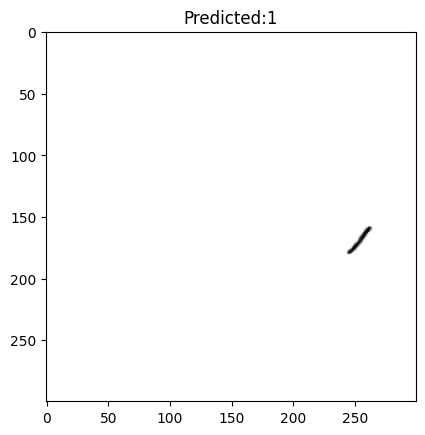

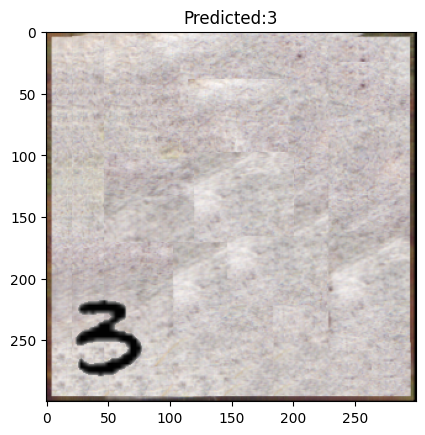

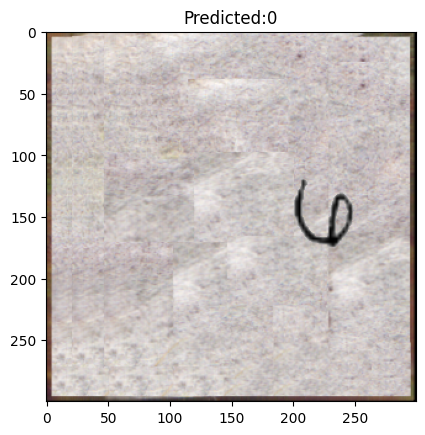

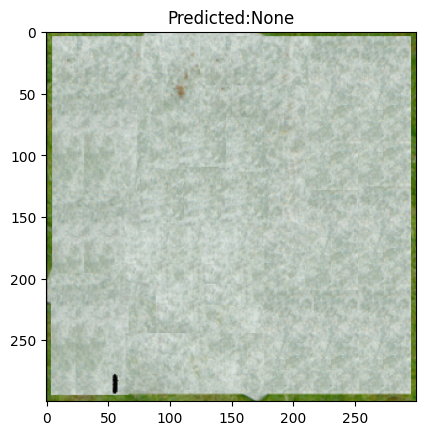

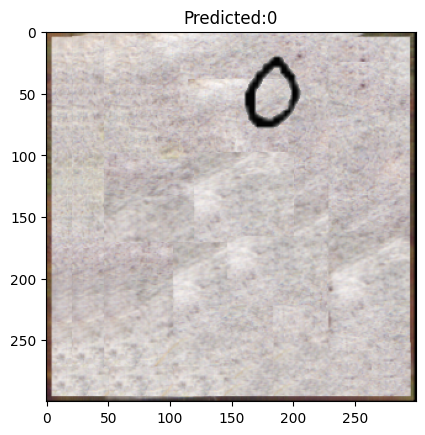

In [43]:
from skimage import io
#test_im = io.imread("https://marketplace.canva.com/EAFq4CUhZFM/1/0/1600w/canva-numbers-1-to-100-square-flashcards-7nLIk20HbUo.jpg")

for im in random.sample(test_images_name,5):
    test_im = cv.imread(f"{im_path}/test/images/{im}")
    outputs = predictor(test_im)
    #v = Visualizer(test_im[:, :, ::-1],
    #                   scale=0.5,
    #                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    #    )
    #out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    out = cv.cvtColor(test_im, cv.COLOR_BGR2RGB)
    
    instances = outputs["instances"]

    if len(instances) == 0:
        pred_class = None  # or -1, or skip
    else:
        pred_class = int(instances.pred_classes[0])
    
    plt.figure()
    #plt.imshow(out.get_image()[:,:,::-1])
    plt.imshow(out)
    plt.title(f"Predicted:{pred_class}")
    plt.show()

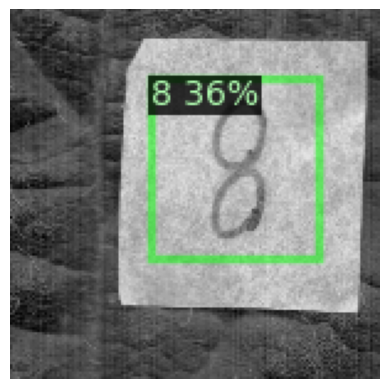

In [38]:
#test = cv.imread("/Users/quino070/Desktop/tag_for_hist.png")
test = cv.imread("/Users/quino070/LeafShapeAnalysis/handwrittenlabels/images/252_1.jpg")
#test = io.imread("https://marketplace.canva.com/EAFq4CUhZFM/1/0/1600w/canva-numbers-1-to-100-square-flashcards-7nLIk20HbUo.jpg")

outputs = predictor(test)
v = Visualizer(test[:, :, ::-1],scale=0.5,
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
instances = outputs["instances"]
pred = np.array(instances.pred_classes)
if len(instances) == 0:
    pred = None  # or -1, or skip
else:
    pred = np.array(instances.pred_classes)
    pred=int("".join(map(str, pred)))

plt.imshow(out.get_image()[:,:,::-1])
plt.axis('off')
#plt.title(f"Predicted:{pred}")
#plt.savefig("/Users/quino070/Desktop/annotated_label.png", dpi=1200)
plt.show()


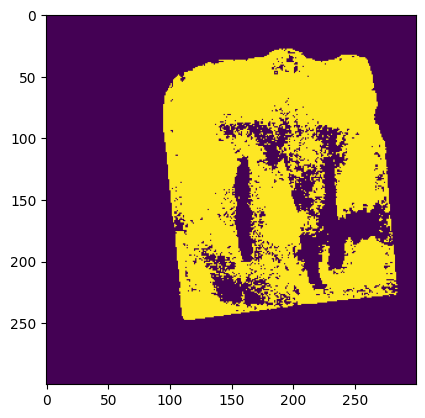

In [14]:
from skimage.restoration import denoise_tv_chambolle
from skimage import color
#test = cv.imread("/Users/quino070/Desktop/tag3.png")
test = cv.imread("/Users/quino070/LeafShapeAnalysis/handwrittenlabels/images/250_4.jpg")
test = cv.resize(test, (300,300), interpolation=cv.INTER_CUBIC)
test = cv.fastNlMeansDenoising(test,5,7,21)
_, test = cv.threshold(cv.cvtColor(test, cv.COLOR_BGR2GRAY), 180,190, cv.THRESH_BINARY)
plt.imshow(test)

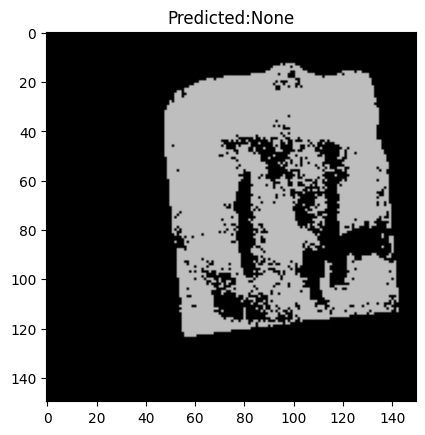

In [15]:
test = cv.cvtColor(test, cv.COLOR_GRAY2BGR)
outputs = predictor(test)
v = Visualizer(test[:, :, ::-1],scale=0.5,
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
instances = outputs["instances"]
pred = np.array(instances.pred_classes)
if len(instances) == 0:
    pred = None  # or -1, or skip
else:
    pred = np.array(instances.pred_classes)
    pred=int("".join(map(str, pred)))

plt.imshow(out.get_image()[:,:,::-1])
plt.title(f"Predicted:{pred}")
plt.show()

In [ ]:
DatasetCatalog.remove("digit_train")
MetadataCatalog.remove("digit_train")
DatasetCatalog.remove("digit_test")
MetadataCatalog.remove("digit_test")